## Dataset Overview
HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma 

## Importing libraries

In [45]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score


## Reading the Data

In [46]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


## Data Preprocessing
## Data Cleaning

In [47]:
data['label'].unique()
y = data['label']
x = data.drop(columns = ['label'])
data.isnull().sum().sum() #no null values present

0

In [48]:
meta_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [49]:
meta_data['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [50]:
data.isnull().sum().sum() #no null values present
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Exploratory Data Analysis

Text(0.5, 1.0, 'Frequency Distribution of Classes')

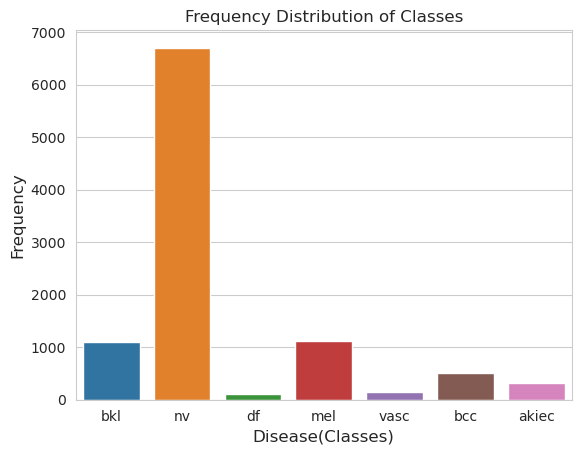

In [51]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease(Classes)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes')

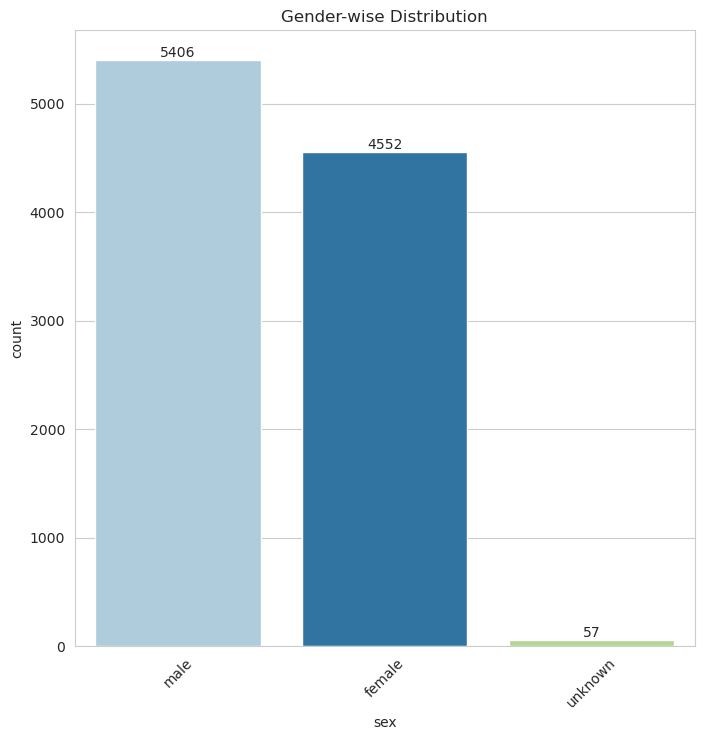

In [52]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(8,8))

ax = sns.countplot(x='sex',data=meta_data, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

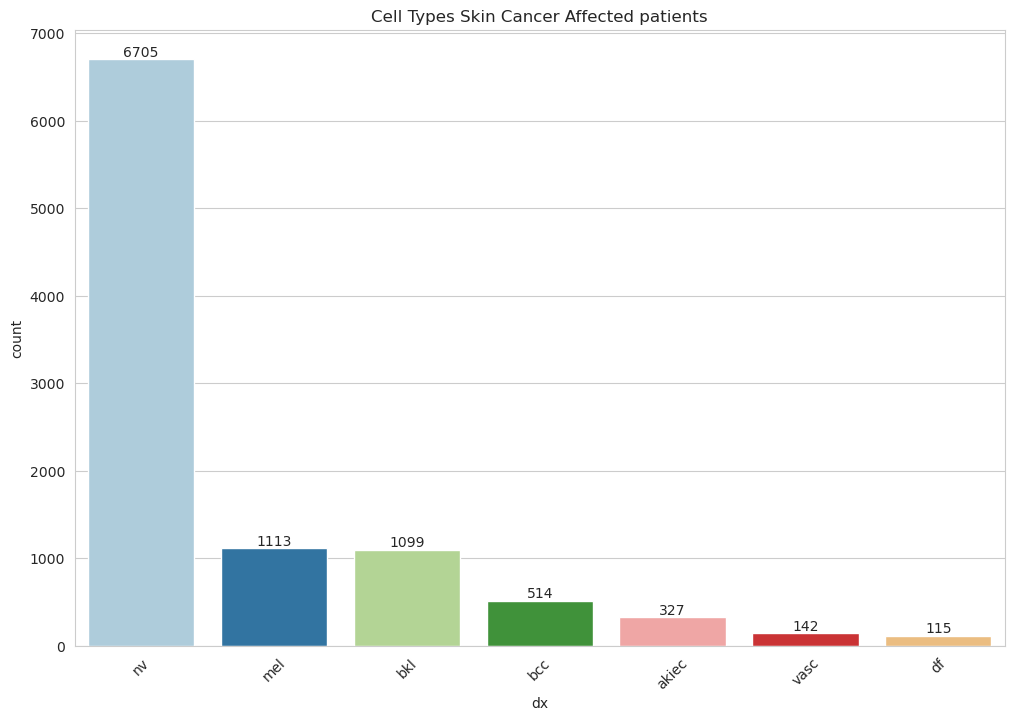

In [53]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

In [54]:
classes = {2:'bkl', 4:'nv', 3:'df', 6:'mel', 5:'vasc', 1:'bcc', 0:'akiec'}

classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)

[2, 4, 3, 6, 5, 1, 0]


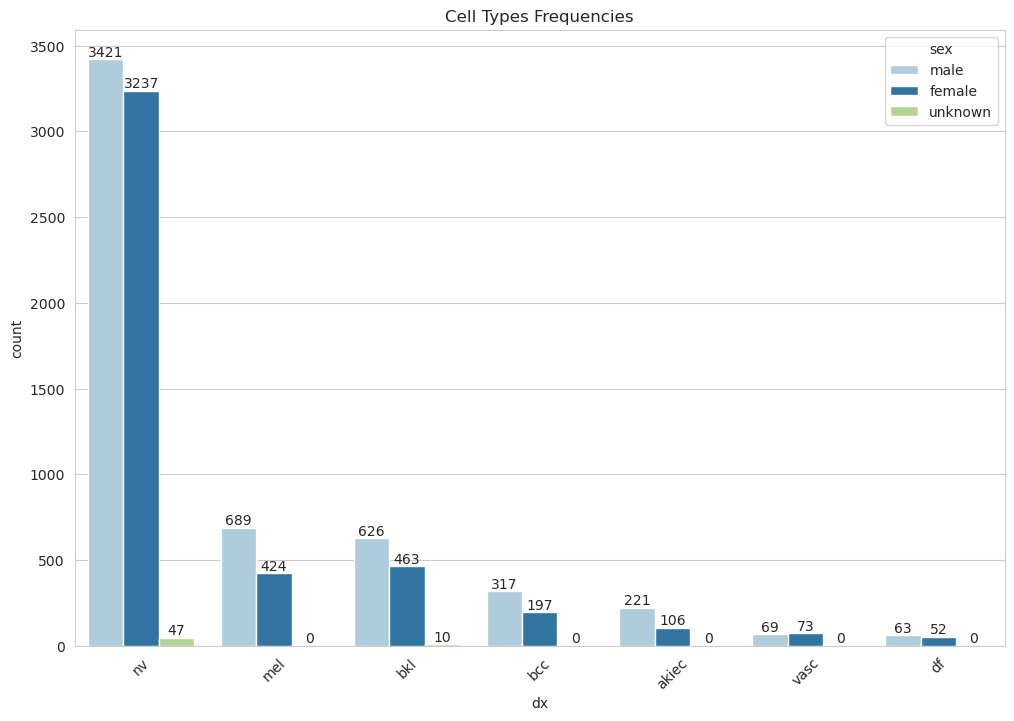

In [55]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',hue='sex', data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

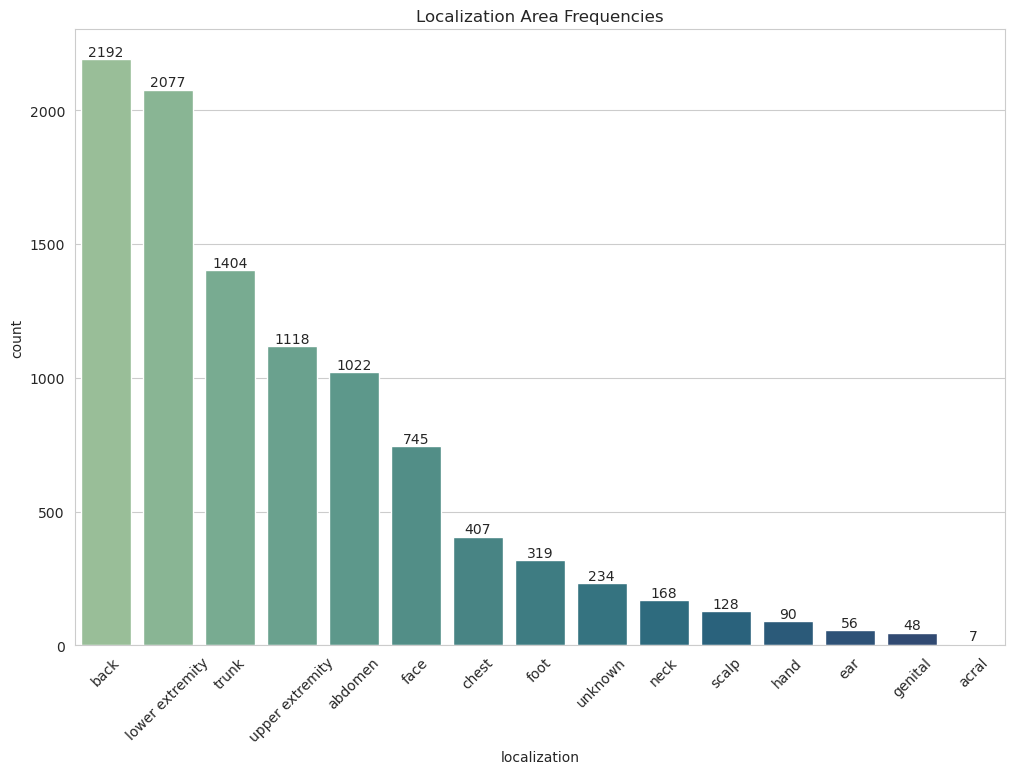

In [56]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=meta_data, order = meta_data['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

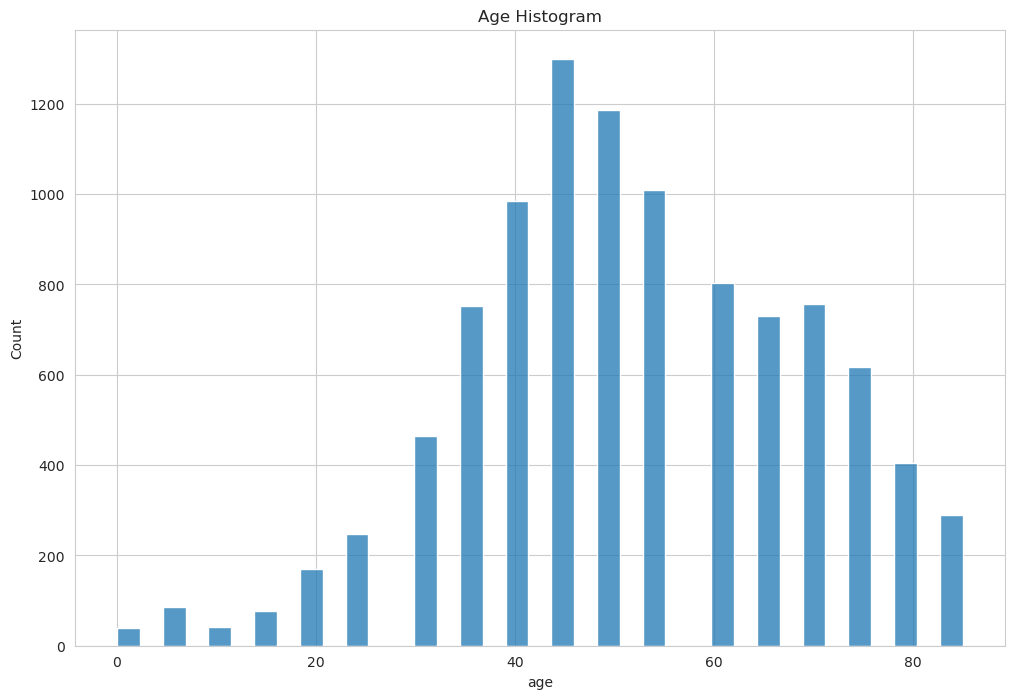

In [57]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age')
plt.title('Age Histogram')
plt.show()

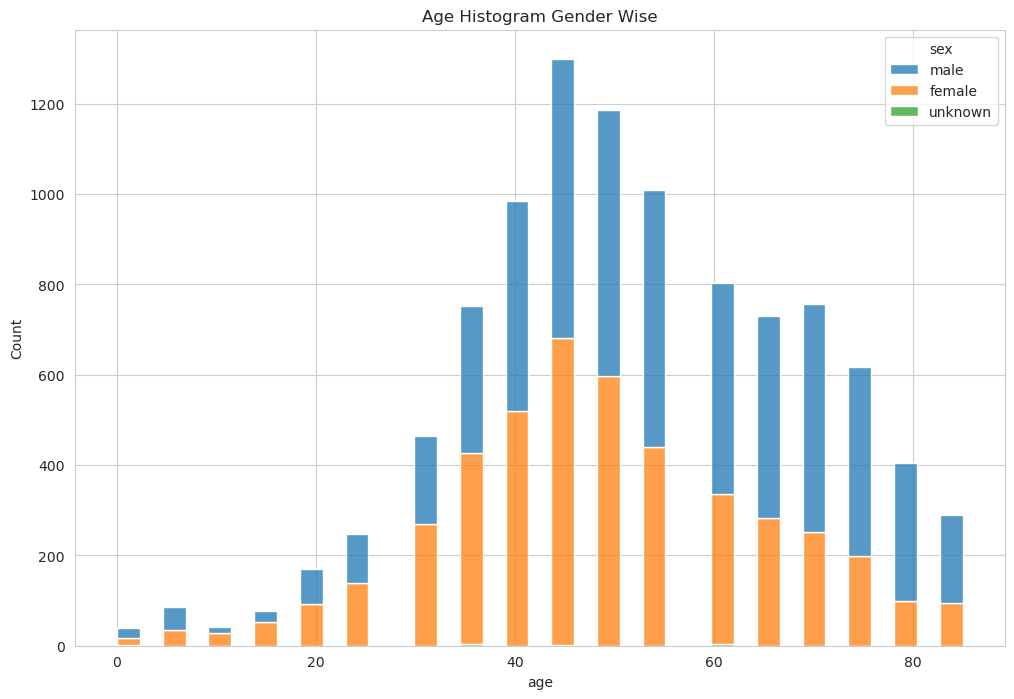

In [58]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise')
plt.show()

In [59]:
print(x.shape,y.shape)
# To overcome class imbalace
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)
print(x.shape,y.shape)

(10015, 2352) (10015,)
(46935, 2352) (46935,)


In [60]:
# reshaping the data so that it can be taken by convolution neural network(without disturbing the no. of samples)
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)
print('Shape of y :',y.shape)

Shape of X : (46935, 28, 28, 3)
Shape of y : (46935,)


In [61]:
# Splitting Data
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)
print(X_train.shape,Y_train.shape)
print(X_test.shape , Y_test.shape)

(37548, 28, 28, 3) (37548,)
(9387, 28, 28, 3) (9387,)


In [62]:
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())


model_CNN.add(MaxPool2D(pool_size = (2,2)))


model_CNN.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model_CNN.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model_CNN.add(Flatten())


model_CNN.add(Dense(64, activation = 'relu'))
model_CNN.add(BatchNormalization())


model_CNN.add(Dense(32))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(16))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(7))
model_CNN.add(Activation(activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_CNN.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
print(model_CNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [63]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
history = model_CNN.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = 50,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/50
470/470 [==============================] - 8s 9ms/step - loss: 0.9652 - accuracy: 0.6624 - val_loss: 0.7836 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 2/50
470/470 [==============================] - 4s 8ms/step - loss: 0.4778 - accuracy: 0.8336 - val_loss: 0.8779 - val_accuracy: 0.6887 - lr: 0.0010
Epoch 3/50
470/470 [==============================] - 4s 8ms/step - loss: 0.2847 - accuracy: 0.8988 - val_loss: 0.5649 - val_accuracy: 0.7887 - lr: 0.0010
Epoch 4/50
470/470 [==============================] - 4s 8ms/step - loss: 0.2255 - accuracy: 0.9206 - val_loss: 0.4857 - val_accuracy: 0.8025 - lr: 0.0010
Epoch 5/50
470/470 [==============================] - 4s 9ms/step - loss: 0.1765 - accuracy: 0.9374 - val_loss: 0.7313 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 6/50
470/470 [==============================] - 4s 9ms/step - loss: 0.1391 - accuracy: 0.9511 - val_loss: 0.3147 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 7/50
470/470 [==============================] - 4s 8ms/step - lo

In [64]:
results = model_CNN.evaluate(X_test , Y_test, verbose=0)

print("CNN Model Test Results")
print("        Test Loss: {:.5f}".format(results[0]))
print("    Test Accuracy: {:.2f}%".format(results[1] * 100))

CNN Model Test Results
        Test Loss: 0.07409
    Test Accuracy: 98.02%


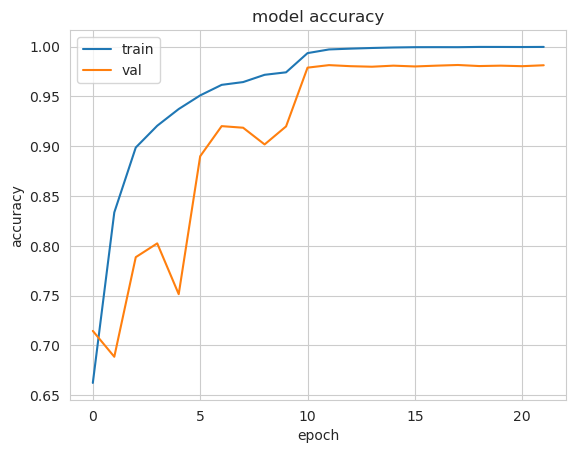

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

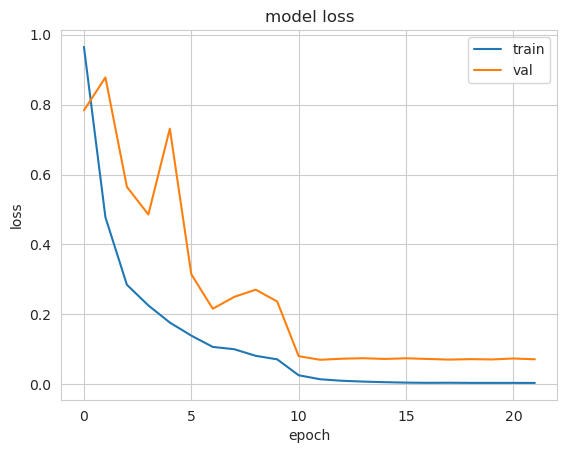

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [67]:
from sklearn.metrics import confusion_matrix , classification_report

y_true_CNN = list(Y_test)
y_pred_CNN = model_CNN.predict(X_test)
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("Predicting First Ten Rows:")
print('Y Actual Values :' , y_true_CNN[0:10])
print('Y Predicted Values :' , y_pred_CNN[0:10])

294/294 [==============================] - 1s 2ms/step
Predicting First Ten Rows:
Y Actual Values : [5, 1, 4, 0, 5, 0, 2, 0, 3, 2]
Y Predicted Values : [5, 1, 4, 0, 5, 0, 2, 0, 3, 2]


[[1253    6    2    1    0    0    0]
 [  55 1215    4   81    4   11    4]
 [   0    0 1351    0    0    0    0]
 [   5    6    0 1354    0    0    0]
 [   0    0    0    0 1358    0    0]
 [   0    0    0    0    0 1314    4]
 [   0    0    3    0    0    0 1356]]


<AxesSubplot:>

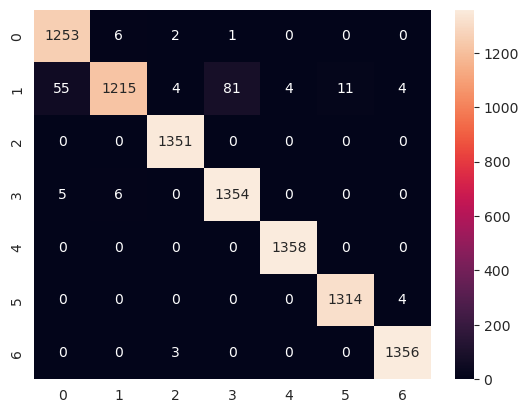

In [68]:
cm_CNN = confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels)
print(confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels))
sns.heatmap(cm_CNN, annot = True, fmt='')

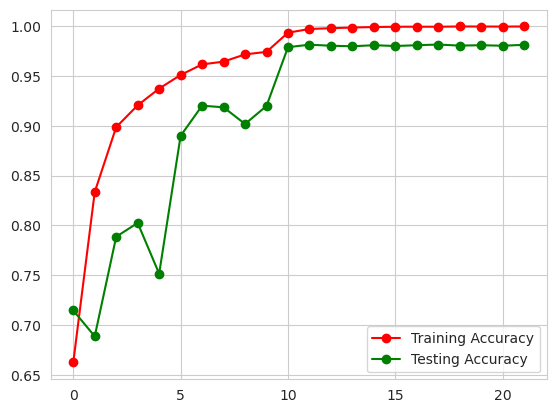

In [69]:
#training acc vs testing acc graph
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

In [70]:
#predicting
y_pred_CNN  = model_CNN.predict(X_test)
target_names = [f"{classes[i]}" for i in range(7)]
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("CNN Model Prediction Results")
print(classification_report(Y_test , y_pred_CNN,target_names=target_names))

294/294 [==============================] - 1s 2ms/step
CNN Model Prediction Results
              precision    recall  f1-score   support

       akiec       0.99      1.00      1.00      1359
         bcc       0.99      1.00      0.99      1318
         bkl       0.95      0.99      0.97      1262
          df       0.99      1.00      1.00      1351
          nv       0.99      0.88      0.93      1374
        vasc       1.00      1.00      1.00      1358
         mel       0.94      0.99      0.97      1365

    accuracy                           0.98      9387
   macro avg       0.98      0.98      0.98      9387
weighted avg       0.98      0.98      0.98      9387



In [71]:
# Layers definitions
from keras import backend as K
for l in range(len(model_CNN.layers)):
    print(l, model_CNN.layers[l])

0 <keras.layers.convolutional.conv2d.Conv2D object at 0x7ff194bbf550>
1 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff285e5ef90>
2 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff28631df50>
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x7ff2668ddf50>
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff2862e6590>
5 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff25fdaba90>
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x7ff194bbf710>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff25fda5b50>
8 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff194d988d0>
9 <keras.layers.reshaping.flatten.Flatten object at 0x7ff25ffcd7d0>
10 <keras.layers.core.dense.Dense object at 0x7ff25fdbfc10>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff2668dd710>
12 <keras.layers.core.dense.Dense object at 0x7ff2

In [72]:
model_CNN.layers[-2]

In [73]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


## Separating Features Layers from the CNN Model

In [74]:
import tensorflow as tf
# feature_extractor = tf.keras.Model(inputs=model_CNN.input, 
#                                     outputs=model_CNN.get_layer(-2).output)
# output_layers_model =tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.output)
# cnn_layer_output = model_CNN.layers[-2].output
# cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=cnn_layer_output)
cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.layers[-3].output)


## Extracting Features from CNN Model

In [75]:
# Extract features from input data using the CNN model
X_train_cnn = cnn_model_features.predict(X_train)
X_test_cnn = cnn_model_features.predict(X_test)

294/294 [==============================] - 1s 2ms/step


## Integrating CNN with SVM Classifier using Grid Search for Best Perameters

In [76]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf=SVC(kernel='rbf',C=100,gamma=0.001)
kf=KFold(n_splits=5)
scores_SVM = cross_val_score(clf, X_train_cnn, Y_train, cv=kf)
print(scores_SVM)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_SVM.mean(), scores_SVM.std()))
clf.fit(X_train_cnn, Y_train)
# Evaluate the combined CNN-SVM model on a test dataset
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)
y_testSVM = clf.predict(X_test_cnn)

[0.99960053 1.         1.         0.99986683 0.98242109]
1.00 accuracy with a standard deviation of 0.01
SVM Accuracy: 98.72163630552893


In [77]:
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)


SVM Accuracy: 98.72163630552893


In [78]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testSVM,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_testSVM)*100))

              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00      1359
         bcc       1.00      1.00      1.00      1318
         bkl       0.97      0.99      0.98      1262
          df       1.00      1.00      1.00      1351
          nv       0.98      0.93      0.96      1374
        vasc       1.00      1.00      1.00      1358
         mel       0.97      0.99      0.98      1365

    accuracy                           0.99      9387
   macro avg       0.99      0.99      0.99      9387
weighted avg       0.99      0.99      0.99      9387

Accuracy: 98.72163630552893


## Integrating CNN with Random Forest Classifier using Grid Search for Best Perameters

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rgclf = RandomForestClassifier(max_depth=3,
               max_features=1,
               min_samples_split=3,
               bootstrap=False,
               criterion=  "entropy",
               n_estimators=20)
kf=KFold(n_splits=5)
scores_RF = cross_val_score(rgclf, X_train_cnn, Y_train, cv=kf)
print(scores_RF)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_RF.mean(), scores_RF.std()))
rgclf.fit(X_train_cnn, Y_train)
RFC_accuracy = rgclf.score(X_test_cnn, Y_test)
print('Random Forest Classifier Accuracy:', RFC_accuracy*100)
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))

[0.99494008 0.99121172 0.99747004 0.99467306 0.96723931]
0.99 accuracy with a standard deviation of 0.01
Random Forest Classifier Accuracy: 97.31543624161074
Accuracy: 97.31543624161074


In [80]:
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))


Accuracy: 97.31543624161074


In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# parameters = {"n_neighbors": [1],
#               "weights": ['uniform', 'distance'],
#               "metric": ['minkowski','euclidean','manhattan'],
#               "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kgclf = KNeighborsClassifier(n_neighbors=1,
              weights='distance',
              metric='euclidean',
              algorithm= 'auto')
kf=KFold(n_splits=5)
scores_KNN = cross_val_score(kgclf, X_train_cnn, Y_train, cv=kf)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_KNN.mean(), scores_KNN.std()))
kgclf.fit(X_train_cnn, Y_train)
KNN_accuracy = kgclf.score(X_test_cnn, Y_test)
print('KNN Classifier Accuracy:', KNN_accuracy*100)

1.00 accuracy with a standard deviation of 0.01
KNN Classifier Accuracy: 98.9879620752104


In [82]:
y_testKNN = kgclf.predict(X_test_cnn)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testKNN,target_names=target_names))
print("Accuracy Score: {0}".format(accuracy_score(Y_test, y_testKNN)*100))

              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00      1359
         bcc       0.99      1.00      1.00      1318
         bkl       0.97      1.00      0.99      1262
          df       1.00      1.00      1.00      1351
          nv       1.00      0.93      0.96      1374
        vasc       1.00      1.00      1.00      1358
         mel       0.97      1.00      0.98      1365

    accuracy                           0.99      9387
   macro avg       0.99      0.99      0.99      9387
weighted avg       0.99      0.99      0.99      9387

Accuracy Score: 98.9879620752104


## Integrating CNN with Logistic Regression Classifier using Grid Search for Best Perameters

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



# Create a logistic regression object
grid_search_LR = LogisticRegression(C=100,
              penalty='l2')
kf=KFold(n_splits=5)
scores_LR = cross_val_score(grid_search_LR, X_train_cnn, Y_train, cv=kf)
print(scores_LR)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_LR.mean(), scores_LR.std()))
# Perform grid search with 5-fold cross-validation
grid_search_LR.fit(X_train_cnn, Y_train)

# Print the best hyperparameters and the corresponding accuracy score
y_test_LR = grid_search_LR.predict(X_test_cnn)

print(classification_report(Y_test, y_test_LR,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_LR)*100))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.99946738 1.         1.         0.99986683 0.98295379]
1.00 accuracy with a standard deviation of 0.01
              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00      1359
         bcc       1.00      1.00      1.00      1318
         bkl       0.97      0.99      0.98      1262
          df       1.00      1.00      1.00      1351
          nv       0.98      0.93      0.95      1374
        vasc       1.00      1.00      1.00      1358
         mel       0.97      0.99      0.98      1365

    accuracy                           0.99      9387
   macro avg       0.99      0.99      0.99      9387
weighted avg       0.99      0.99      0.99      9387

Accuracy: 98.68967721316714


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
